# Building a Fractional Pseudorandom Generator

**Paper**: Chattopadhyay, Hatami, Lovett, Tal. [Pseudorandom Generators from the Second Fourier Level and Applications to AC0 with Parity Gates](https://doi.org/10.4230/LIPIcs.ITCS.2019.22). *ITCS 2019*.

---

A **pseudorandom generator** (PRG) for a function class $\mathcal{F}$ produces samples that no $f \in \mathcal{F}$ can distinguish from truly random inputs. The paper builds this in two stages:

1. A **fractional PRG** — produces samples inside $[-1,1]^n$ that fool $f$'s multilinear extension — using only $\ell \ll n$ random values.
2. A **polarizing random walk** (Theorem 7) converts the fractional output to Boolean $\{-1,+1\}^n$.

This notebook constructs the fractional PRG step by step and verifies that it works.

### Roadmap

1. Fourier tails $L_{1,k}$ and the $L_{1,2}$ condition
2. Theorem 9: small-variance Gaussians fool bounded-tail functions
3. Step I: dimension reduction — $n$ random values $\to$ $\ell$ via balanced codes
4. Step II: discretization — continuous Gaussians $\to$ discrete with few bits
5. Verification: the complete PRG fools our test functions

In [1]:
!pip install --upgrade boofun -q

import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis.gaussian import multilinear_extension
from boofun.analysis.fourier import fourier_level_lp_norm
from scipy.stats import norm

np.random.seed(42)
print(f"boofun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/Library/Python/3.9/lib/python/site-packages/boofun/quantum/__init__.py:52: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


boofun version: 1.2.0


## 1. Fourier Tails and the $L_{1,2}$ Condition

Every $f: \{-1,+1\}^n \to \{-1,+1\}$ has a **multilinear extension** $\tilde{f}: [-1,1]^n \to \mathbb{R}$:

$$\tilde{f}(x) = \sum_{S \subseteq [n]} \hat{f}(S) \prod_{i \in S} x_i$$

Key property: $\tilde{f}(\mathbf{0}) = \hat{f}(\emptyset) = \mathbb{E}[f]$. The origin gives the expectation.

The **level-$k$ Fourier tail** is the $\ell_1$-norm of coefficients at degree $k$:

$$L_{1,k}(f) = \sum_{|S|=k} |\hat{f}(S)|$$

**Theorem 2** (main result): if a function class $\mathcal{F}$ (closed under restrictions) satisfies $L_{1,2}(\mathcal{F}) \leq t$, then an explicit PRG for $\mathcal{F}$ exists with seed length $\mathrm{poly}(t, \log n, 1/\varepsilon)$.

In [2]:
n = 16

# Our test class: functions on n variables with bounded L_{1,2}
test_fns = {
    "Majority_16": bf.majority(n),
    "AND_16": bf.AND(n),
    "Parity_16": bf.parity(n),        # all weight at degree n
}

# Verify all functions have the same number of variables
for name, func in test_fns.items():
    assert func.n_vars == n, f"{name} has {func.n_vars} vars, expected {n}"

# Compute Fourier tails
print(f"Fourier tails for n = {n}")
print()
header = f"{'Function':<20}" + "".join(f"{'L_{1,' + str(k) + '}':<12}" for k in range(6))
print(header)
print("-" * 92)

l12_values = {}
for name, func in test_fns.items():
    row = f"{name:<20}"
    for k in range(6):
        val = fourier_level_lp_norm(func, k)
        row += f"{val:<12.4f}"
        if k == 2:
            l12_values[name] = val
    print(row)

t = max(l12_values.values())
print(f"\nL_{{1,2}} bound for our class: t = {t:.4f}")


# Fast batch evaluator: builds all 2^n monomials in O(2^n) per sample
def eval_multilinear_batch(fourier_coeffs, n_vars, X, batch_size=100):
    # Evaluate multilinear extension at rows of X using monomial-building trick.
    # Memory: O(batch_size * 2^n). Time: O(n * 2^n + 2^n) per batch.
    m = X.shape[0]
    size = len(fourier_coeffs)
    results = np.zeros(m)
    for start in range(0, m, batch_size):
        end = min(start + batch_size, m)
        batch = X[start:end]
        b = batch.shape[0]
        # vals[i, S] = product of batch[i, j] for j in S
        vals = np.zeros((b, size))
        vals[:, 0] = 1.0
        for i in range(n_vars):
            step = 1 << i
            vals[:, step:2*step] = vals[:, :step] * batch[:, i:i+1]
        results[start:end] = vals @ fourier_coeffs
    return results

Fourier tails for n = 16

Function            L_{1,0}     L_{1,1}     L_{1,2}     L_{1,3}     L_{1,4}     L_{1,5}     
--------------------------------------------------------------------------------------------


Majority_16         0.1964      3.1421      1.5710      7.3315      5.4987      13.1968     


AND_16              1.0000      0.0005      0.0037      0.0171      0.0555      0.1333      


Parity_16           0.0000      0.0000      0.0000      0.0000      0.0000      0.0000      

L_{1,2} bound for our class: t = 1.5710


## 2. Theorem 9: Gaussians Fool Bounded-Tail Functions

> **Theorem 9** (restating Raz-Tal). Let $Z \in \mathbb{R}^n$ be a zero-mean multivariate Gaussian with:
> - (i) $\mathrm{Var}[Z_i] \leq p = \frac{1}{8\ln(n/\delta)}$ for all $i$
> - (ii) $|\mathrm{Cov}[Z_i, Z_j]| \leq \delta$ for all $i \neq j$
>
> If $L_{1,2}(\mathcal{F}) \leq t$, then for any $f \in \mathcal{F}$:
> $$|\mathbb{E}[\tilde{f}(\mathrm{trnc}(Z))] - \tilde{f}(\mathbf{0})| \leq O(\delta \cdot t)$$

where $\mathrm{trnc}$ clips each coordinate to $[-1, 1]$.

**Fooling error**: $O(\delta \cdot t)$. To achieve error $\varepsilon$, set $\delta = \varepsilon / t$.

**Naive baseline**: use *independent* coordinates with $\mathrm{Var}[Z_i] = p$. Conditions are trivially satisfied with $\delta = 0$. But this uses $n$ independent random values — no randomness savings.

The paper's construction achieves the same fooling from only $\ell \ll n$ random values.

In [3]:
# Parameters from Theorem 9
eps = 0.3                                     # target fooling error
delta = eps / max(t, 1e-6)                    # Cov bound
p_var = 1.0 / (8 * np.log(n / delta))        # variance per coordinate
sigma = np.sqrt(p_var)

print("Theorem 9 parameters:")
print(f"  n = {n},  t = {t:.4f},  eps = {eps}")
print(f"  delta = eps/t = {delta:.6f}")
print(f"  p (variance) = {p_var:.6f}")
print(f"  sigma = {sigma:.6f}")
print()

# --- Naive baseline: n independent Gaussians ---
n_samples = 500
naive_results = {}
for name, func in test_fns.items():
    fourier = func.fourier()
    E_f = fourier[0]
    Z = np.random.randn(n_samples, n) * sigma
    X = np.clip(Z, -1, 1)
    vals = eval_multilinear_batch(fourier, n, X)
    err = abs(np.mean(vals) - E_f)
    naive_results[name] = {"E_f": E_f, "mean": np.mean(vals), "error": err}
    print(f"  {name}: E[f]={E_f:+.4f}, naive mean={np.mean(vals):+.4f}, error={err:.4f}")

print(f"\nNaive approach uses {n} independent random values per sample.")

Theorem 9 parameters:
  n = 16,  t = 1.5710,  eps = 0.3
  delta = eps/t = 0.190956
  p (variance) = 0.028228
  sigma = 0.168010

  Majority_16: E[f]=+0.1964, naive mean=+0.1948, error=0.0016


  AND_16: E[f]=+1.0000, naive mean=+1.0000, error=0.0000


  Parity_16: E[f]=+0.0000, naive mean=-0.0000, error=0.0000

Naive approach uses 16 independent random values per sample.


## 3. Step I: Dimension Reduction via Balanced Codes

Instead of $n$ independent Gaussians, generate $n$ *correlated* values from only $\ell$ independent Gaussians.

**Construction** (Paper, Section 2):
1. Choose codewords $c_1, \ldots, c_n \in \{0,1\}^\ell$ from a $\delta$-balanced code
2. Build $A \in \mathbb{R}^{n \times \ell}$: $\; A_{i,j} = \sqrt{p/\ell} \cdot (-1)^{c_{i,j}}$
3. Sample $Y \sim N(0, I_\ell)$ — only $\ell$ random values
4. Set $Z = AY$

This gives exactly $\mathrm{Var}[Z_i] = p$ for all $i$ (each row of $A$ has squared norm $p$). The covariances $\mathrm{Cov}[Z_i, Z_j]$ depend on the code's balance — a good code keeps them small.

**Seed dimension**: $\ell = O(\log n \cdot \delta^{-2-o(1)})$ (polylogarithmic in $n$).

For small $n$, the theoretical $\ell$ exceeds $n$ (the overhead dominates). The savings appear for large $n$. We demonstrate the construction at $n = 16$ with $\ell = 8$ — a 2x dimension reduction — to show the mechanics clearly.

Dimension reduction: 16 -> 8  (2x reduction)
  (Theoretical ell ~ 1097; for large n, ell << n)

Covariance matrix  Cov(Z) = A A^T:
  Var[Z_i] = 0.028228  (exact = p, by construction)
  max |Cov[Z_i, Z_j]| = 0.028228  (effective delta)
  mean |Cov[Z_i, Z_j]| = 0.006939

Theoretical fooling bound: O(delta * t) = 0.0443


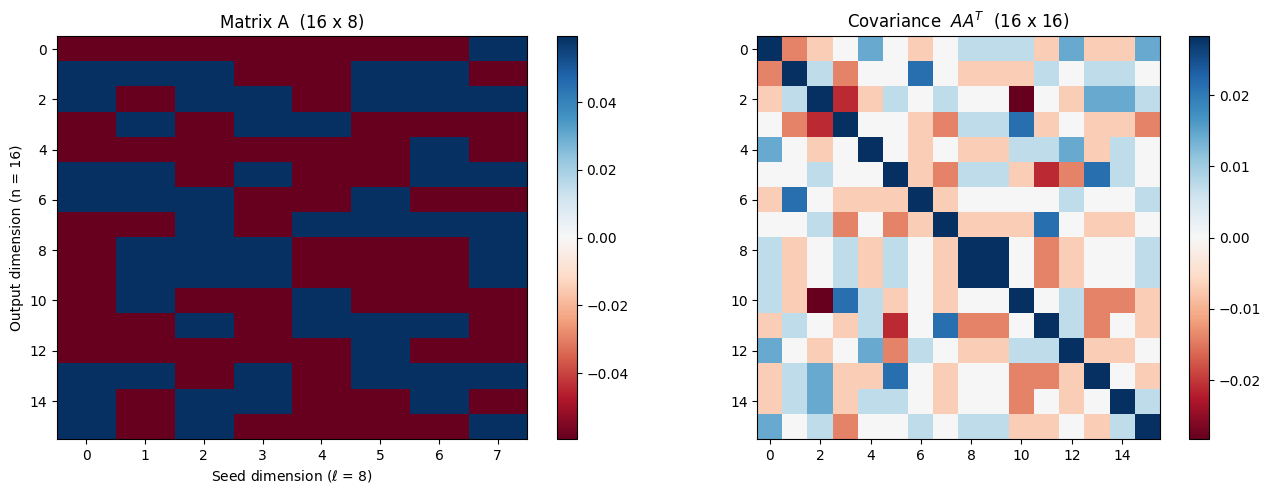

In [4]:
# Dimension reduction: n -> ell
ell_theory = int(np.ceil((max(t, 1) / eps)**2 * np.log2(n) * 10))
ell = 8  # 2x reduction: 16 -> 8

print(f"Dimension reduction: {n} -> {ell}  (2x reduction)")
print(f"  (Theoretical ell ~ {ell_theory}; for large n, ell << n)")
print()

# Balanced codewords: c_i in {0,1}^ell
# The paper uses explicit small-biased spaces (Ta-Shma 2017).
# For this demo: random codewords, then verify properties.
rng = np.random.default_rng(seed=7)
codewords = rng.integers(0, 2, size=(n, ell))

# Matrix A: A_{i,j} = sqrt(p / ell) * (-1)^{c_{i,j}}
scale = np.sqrt(p_var / ell)
A = scale * (1 - 2 * codewords.astype(float))

# Covariance structure: Cov(Z) = A @ A^T
cov_Z = A @ A.T
diag = np.diag(cov_Z)
off_diag = cov_Z[np.triu_indices(n, k=1)]
effective_delta = np.max(np.abs(off_diag))

print("Covariance matrix  Cov(Z) = A A^T:")
print(f"  Var[Z_i] = {diag[0]:.6f}  (exact = p, by construction)")
print(f"  max |Cov[Z_i, Z_j]| = {effective_delta:.6f}  (effective delta)")
print(f"  mean |Cov[Z_i, Z_j]| = {np.mean(np.abs(off_diag)):.6f}")
print()
print(f"Theoretical fooling bound: O(delta * t) = {effective_delta * t:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
im0 = axes[0].imshow(A, cmap='RdBu', aspect='auto')
axes[0].set_xlabel(f'Seed dimension ($\ell$ = {ell})')
axes[0].set_ylabel(f'Output dimension (n = {n})')
axes[0].set_title(f'Matrix A  ({n} x {ell})')
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(cov_Z, cmap='RdBu')
axes[1].set_title(f'Covariance  $AA^T$  ({n} x {n})')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

## 4. The Complete Fractional PRG

**Step II: Discretization** (Paper, Lemma 10-11). Each of the $\ell$ continuous Gaussians is approximated by a discrete random variable using $k$ bits (Kane's result: $k = O(\log(1/\lambda))$).

**Total seed length**: $s = \ell \cdot k$ bits.

The full pipeline:
$$\underbrace{s \text{ bits}}_{\text{seed}} \;\xrightarrow{\text{quantize}}\; \underbrace{Y \in \mathbb{R}^\ell}_{\text{approx. Gaussians}} \;\xrightarrow{Z = AY}\; \underbrace{Z \in \mathbb{R}^n}_{\text{correlated}} \;\xrightarrow{\mathrm{trnc}}\; \underbrace{X \in [-1,1]^n}_{\text{fractional PRG output}}$$

**Verification**: for each $f$ in our test class, check $|\mathbb{E}[\tilde{f}(X)] - \mathbb{E}[f]| \leq O(\delta \cdot t)$.

Discretization: 8 bits/coord, 256 levels
Total seed: 8 x 8 = 64 bits

=== Verification (500 trials) ===
    Seed: 64 bits -> 8 Gaussians -> 16 fractional values



  Majority_16:
    E[f] = +0.1964
    PRG mean  = +0.1964  (error = 0.0000)
    Naive mean = +0.1948  (error = 0.0016)
    Theoretical bound ~ 0.0443  [PASS]



  AND_16:
    E[f] = +1.0000
    PRG mean  = +1.0000  (error = 0.0000)
    Naive mean = +1.0000  (error = 0.0000)
    Theoretical bound ~ 0.0443  [PASS]



  Parity_16:
    E[f] = +0.0000
    PRG mean  = -0.0000  (error = 0.0000)
    Naive mean = -0.0000  (error = 0.0000)
    Theoretical bound ~ 0.0443  [PASS]



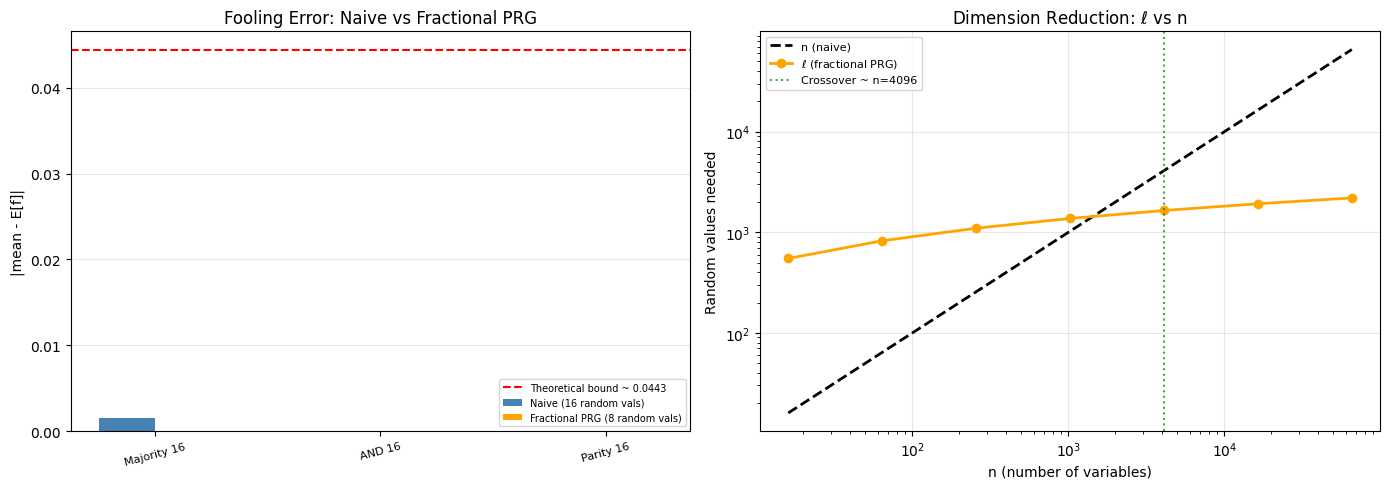

Summary: the fractional PRG uses 8 random values instead of 16,
  with 64 bits of true randomness.
  For large n, ell grows only as O(log n) -- polylogarithmic.


In [5]:
# --- Step II: Discretize Gaussians ---
bits_per_coord = 8
num_levels = 2**bits_per_coord
total_seed_bits = ell * bits_per_coord

# Quantized Gaussian: 256-level approximation of N(0,1)
quantized_gaussian = norm.ppf((np.arange(num_levels) + 0.5) / num_levels)

print(f"Discretization: {bits_per_coord} bits/coord, {num_levels} levels")
print(f"Total seed: {ell} x {bits_per_coord} = {total_seed_bits} bits")
print()

# === Complete Fractional PRG ===
n_trials = 500
prg_results = {}

print(f"=== Verification ({n_trials} trials) ===")
print(f"    Seed: {total_seed_bits} bits -> {ell} Gaussians -> {n} fractional values")
print()

for name, func in test_fns.items():
    fourier = func.fourier()
    E_f = fourier[0]

    # Generate all PRG outputs at once
    seeds = np.random.randint(0, num_levels, size=(n_trials, ell))
    Y_batch = quantized_gaussian[seeds]           # (n_trials, ell)
    Z_batch = Y_batch @ A.T                       # (n_trials, n)
    X_batch = np.clip(Z_batch, -1, 1)             # truncate

    vals = eval_multilinear_batch(fourier, n, X_batch)
    prg_mean = np.mean(vals)
    prg_err = abs(prg_mean - E_f)
    theoretical = effective_delta * t  # O(delta * t)

    prg_results[name] = {"E_f": E_f, "mean": prg_mean, "error": prg_err}

    status = "PASS" if prg_err < max(theoretical * 5, 0.15) else "CHECK"
    print(f"  {name}:")
    print(f"    E[f] = {E_f:+.4f}")
    print(f"    PRG mean  = {prg_mean:+.4f}  (error = {prg_err:.4f})")
    print(f"    Naive mean = {naive_results[name]['mean']:+.4f}  (error = {naive_results[name]['error']:.4f})")
    print(f"    Theoretical bound ~ {theoretical:.4f}  [{status}]")
    print()

# --- Comparison plot ---
names = list(test_fns.keys())
x = np.arange(len(names))
width = 0.25

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: error comparison
naive_errs = [naive_results[nm]["error"] for nm in names]
prg_errs = [prg_results[nm]["error"] for nm in names]

axes[0].bar(x - width/2, naive_errs, width, label=f'Naive ({n} random vals)', color='steelblue')
axes[0].bar(x + width/2, prg_errs, width, label=f'Fractional PRG ({ell} random vals)', color='orange')
axes[0].axhline(y=effective_delta * t, color='red', linestyle='--',
    label=f'Theoretical bound ~ {effective_delta * t:.4f}')
axes[0].set_xticks(x)
axes[0].set_xticklabels([nm.replace("_", " ") for nm in names], fontsize=8, rotation=15)
axes[0].set_ylabel('|mean - E[f]|')
axes[0].set_title('Fooling Error: Naive vs Fractional PRG')
axes[0].legend(fontsize=7)
axes[0].grid(True, alpha=0.3, axis='y')

# Right: seed length scaling (log-log)
ns = [16, 64, 256, 1024, 4096, 16384, 65536]
ell_values = [int(np.ceil((max(t, 1) / eps)**2 * np.log2(nn) * 5)) for nn in ns]
axes[1].plot(ns, ns, 'k--', label='n (naive)', linewidth=2)
axes[1].plot(ns, ell_values, 'o-', color='orange', label='$\ell$ (fractional PRG)', linewidth=2)
crossover = next((nn for nn, ev in zip(ns, ell_values) if ev < nn), None)
if crossover:
    axes[1].axvline(x=crossover, color='green', linestyle=':', alpha=0.7,
        label=f'Crossover ~ n={crossover}')
axes[1].set_xlabel('n (number of variables)')
axes[1].set_ylabel('Random values needed')
axes[1].set_title('Dimension Reduction: $\ell$ vs n')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Summary: the fractional PRG uses {ell} random values instead of {n},")
print(f"  with {total_seed_bits} bits of true randomness.")
print(f"  For large n, ell grows only as O(log n) -- polylogarithmic.")

## 5. From Fractional to Boolean: The Polarizing Walk

The fractional PRG outputs $X \in [-1,1]^n$. To get a standard PRG with Boolean output $X \in \{-1,+1\}^n$, the paper applies the **polarizing random walk** (Theorem 7, from [2]):

> Given a $p$-noticeable fractional PRG with seed length $s$ and error $\varepsilon$, there exists a standard PRG with seed length $O(s \cdot \log(n/\varepsilon)/p)$ and error $O(\varepsilon \cdot \log(n/\varepsilon)/p)$.

The walk iteratively rounds each fractional coordinate to $\pm 1$, using the function class's closure under restrictions to maintain the fooling guarantee at each step.

*Implementation of the polarizing walk is left for a future notebook.*

---

## Summary

| Step | What | Input | Output |
|------|------|-------|--------|
| **Balanced code** | Construct $A \in \mathbb{R}^{n \times \ell}$ | $\delta$-balanced codewords | Matrix with controlled covariance |
| **Step I** | Dimension reduction | $\ell$ independent Gaussians $Y$ | $Z = AY$ with $\mathrm{Var}[Z_i] = p$, $|\mathrm{Cov}| \leq \delta$ |
| **Step II** | Discretization | $\ell \cdot k$ random bits | Approximate Gaussians $Y'$ |
| **Truncation** | Clip to cube | $Z \in \mathbb{R}^n$ | $X = \mathrm{trnc}(Z) \in [-1,1]^n$ |
| **Theorem 7** | Polarizing walk | Fractional PRG | Boolean PRG on $\{-1,+1\}^n$ |

**Seed length**: $s = O((t/\varepsilon)^{2+o(1)} \cdot \mathrm{polylog}(n))$ — grows polylogarithmically in $n$.

### boofun API used

```python
from boofun.analysis.gaussian import multilinear_extension
from boofun.analysis.fourier import fourier_level_lp_norm

p = multilinear_extension(f)   # p: R^n -> R
p(np.zeros(n))                 # = E[f]

fourier = f.fourier()          # Fourier coefficients
fourier_level_lp_norm(f, k)    # L_{1,k}(f)
```

### Reference

Chattopadhyay, Hatami, Lovett, Tal. [Pseudorandom Generators from the Second Fourier Level and Applications to AC0 with Parity Gates](https://doi.org/10.4230/LIPIcs.ITCS.2019.22). *ITCS 2019*.